In [3]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\test'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  

load_data = np.array(image_arrays)

In [5]:
load_data.dtype

dtype('float32')

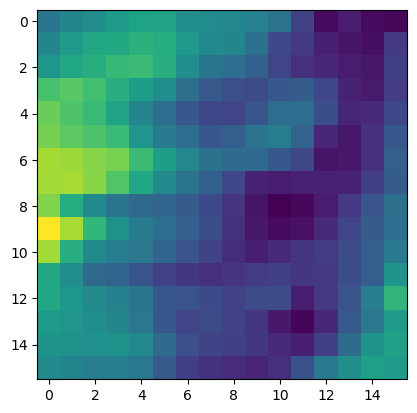

In [7]:
import matplotlib.pyplot as plt
plt.imshow(load_data[3])

In [8]:
load_data.shape

(100, 16, 16, 1)

In [9]:
load_data.dtype

dtype('float32')

In [10]:
from sklearn.model_selection import train_test_split
labels = np.random.randint(0, 16, size=(load_data.shape[0],))
trainX, testX, trainy, testy = train_test_split(load_data,labels, test_size=0.2, random_state=42)

In [11]:
def load_real_samples():
    x = trainX.astype('float32')
    x = (x-127.5)/127.5
    return x

In [12]:
dataset = load_real_samples()

In [16]:
def generate_real_samples(dataset,n_samples):
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    x=dataset[ix]
    y=np.ones((n_samples,1))
    return x,y

In [17]:
n_samples = 30
x,y = generate_real_samples(dataset,n_samples)

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout,Input



# real
def define_discriminator():
    model = Sequential()
    #model.add(Input(shape=(16, 16, 3)))  # Assuming the input is grayscale
    model.add(Conv2D(27, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    #model.add(Conv2D(3, (3,3), padding='same'))
    model.add(Conv2DTranspose(3,(3, 3), padding='same',strides=(2,2)))                             #activation='relu',input_shape=(16, 16, 1)
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    model.add(resnet50)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Reshape((8, 8, 2)))
    model.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Reshape((16, 16,3)))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    return model


In [19]:
d_model = define_discriminator()
d_model.summary()

C:\jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\jupyter\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 27)          │             270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 3)           │             732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 3)           │              57 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,153,892 (92.14 MB)

 Trainable params: 24,100,772 (91.94 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
def define_generator():
    model = Sequential()
    
    # Dense layer to project and reshape the latent space
    model.add(Conv2D(27, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    model.add(Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

 
    model.add(Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')) #strides=(2, 2),
    model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    model.add(resnet50)#     model.add(Flatten())
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (3, 3), activation='tanh', padding='same'))
    
    return model

In [24]:
# latent_dim =256
g_model = define_generator()
g_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 27)          │             270 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │          31,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 3)           │           3,459 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 2, 2, 128)           │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,721,170 (101.93 MB)

 Trainable params: 26,668,050 (101.73 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\train'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  
modified_data = np.array(image_arrays)

In [28]:
modified_data.shape

(80, 16, 16, 1)

In [29]:
modified_data.dtype

dtype('float32')

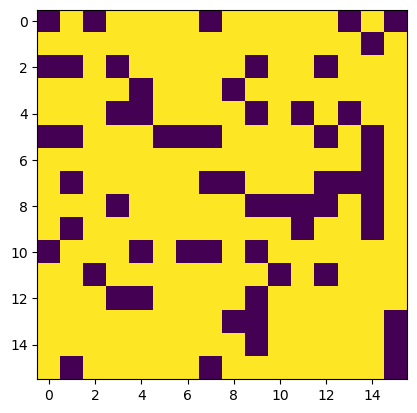

In [30]:
plt.imshow(modified_data[79])

In [31]:
# x  =  g_model.predict(modified_data)

In [32]:
# def generate_fake_samples(g_model, modified_data):
#     x=g_model.predict(modified_data)
#     return x


In [33]:
def generate_fake_samples(g_model, modified_data):
    
    x = g_model.predict(modified_data)
    return x


In [34]:
g_model = define_generator()
x = generate_fake_samples(g_model,modified_data)


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step  


In [36]:
x.shape

(80, 16, 16, 1)

In [37]:
x.dtype

dtype('float32')

In [38]:
# def generate_fake_samples(g_model, modified_data):
#     x= g_model.predict(modified_data)
#     return x

In [39]:
# x = generate_fake_samples(g_model, modified_data)

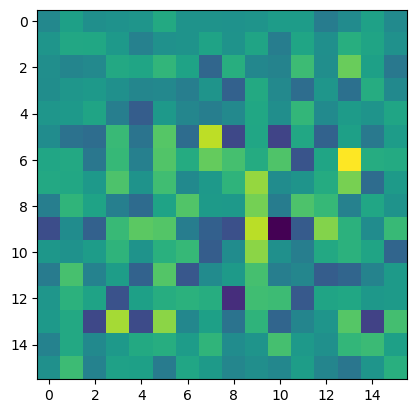

In [40]:
plt.imshow(x[2]*255)

In [43]:
def define_gan(g_model,d_model):
    d_model.trainable=False
    model=Sequential()
    model.add(g_model)
    model.add(d_model)
    opt=Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    return model

In [44]:
gan_model= define_gan(g_model,d_model)

In [45]:
gan_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 16, 16, 1)           │      26,721,170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │      24,153,892 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,875,062 (194.07 MB)

 Trainable params: 26,668,050 (101.73 MB)

 Non-trainable params: 24,207,012 (92.34 MB)

In [47]:
# real
def train(g_model, d_model, gan_model, modified_data ,dataset, n_epochs=2, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = modified_data[:50][:int(n_batch/2)]
    for i in range(n_epochs): 
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch.shape[0]) #
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, half_batch), np.zeros((half_batch.shape[0], 1))#half_batch
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            X_gan, y_gan = generate_fake_samples(g_model, half_batch), np.ones((half_batch.shape[0], 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'd_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}')
        
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, half_batch.shape[0])

In [55]:
def summarize_performance(epoch, g_model, d_model, dataset,n_samples=32):
    X_real, y_real = generate_real_samples(dataset,n_samples) 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model,n_samples) 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(X_fake,epoch)
    filename = os.path.join(r'C:\Users\OptiSAR\Desktop\gan\save_image', "generate_model_%03d.h5" % (epoch+1))
    g_model.save(filename)

In [56]:
# def save_plot(examples, epoch, n=7):
#     examples = (examples + 1) / 2.0
#     for i in range(n * n):
#         pyplot.subplot(n, n, 1 + i)
#         pyplot.axis('off')
#         pyplot.imshow(examples[i])
#         filename = 'generated_plot_e%03d.png' % (epoch+1)
#         pyplot.savefig(filename)
#         pyplot.close()


In [57]:
from matplotlib import pyplot
save_dir=r'C:\Users\OptiSAR\Desktop\gan\save image'
def save_plot(examples, epoch, n=7, save_dir=r'C:\Users\OptiSAR\Desktop\gan\save image'):
    # Normalize the images
    examples = (examples + 1) / 2.0
    if not os.path.exist(save_dir):
        os.makedirs(save_dir)
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = os.path.join(save_dir, 'generated_plot_e%03d.tif' % (epoch+1))
    pyplot.savefig(filename, format='tif')
    pyplot.close()

In [355]:
train(g_model, d_model, gan_model, dataset, modified_data, n_epochs=9, n_batch=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
d_loss1: 0.7164561748504639, d_loss2: 0.8197965621948242, g_loss: [array(0.6998595, dtype=float32), array(0.6998595, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
d_loss1: 0.7305658459663391, d_loss2: 0.7546534538269043, g_loss: [array(0.6998595, dtype=float32), array(0.6998595, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
d_loss1: 0.714465856552124, d_loss2: 0.7182028293609619, g_loss: [array(0.6998595, dtype=float32), array(0.6998595, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
d_loss1: 0.695198118686676, d_loss2: 0.703008770942688, g_loss: [array(0.6998595, dtype=float32), array(0.6998595, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
d_loss1: 0.6823083758354187, d_loss2: 0.6881582140922546, g_loss: [array(0.699859

In [109]:
im_out = g_model.predict(x1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [107]:
x1= modified_data[:1]

In [111]:
print(im_out[].shape)

(1, 16, 16, 1)


In [103]:
x1.shape

(1, 16, 16, 1)

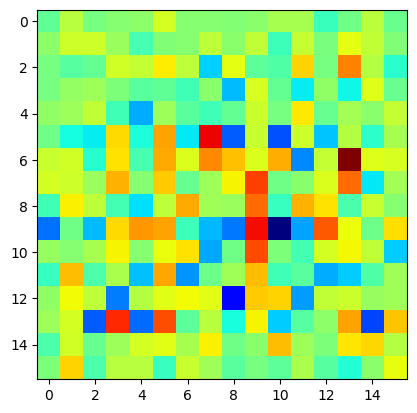

In [123]:
plt.imshow(im_out[0,:,:,0], cmap = 'jet')